In [28]:
import torch
from torch import nn
from torch.utils import model_zoo
import torchvision
import numpy as np
import pandas as pd

In [2]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'insightface': 'https://github.com/foamliu/InsightFace-v3/releases/download/v1.0/insight-face-v3.pt',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.PReLU(),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class IRBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_se=True):
        super(IRBlock, self).__init__()
        self.bn0 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.prelu = nn.PReLU()
        self.conv2 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.use_se = use_se
        if self.use_se:
            self.se = SEBlock(planes)

    def forward(self, x):
        residual = x
        out = self.bn0(x)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.prelu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_se:
            out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.prelu(out)

        return out
class ResNet(nn.Module):

    def __init__(self, block, layers, use_se=True, im_size=112):
        self.inplanes = 64
        self.use_se = use_se
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.bn2 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()

        if im_size == 112:
            self.fc = nn.Linear(512 * 7 * 7, 512)
        else:  # 224
            self.fc = nn.Linear(512 * 14 * 14, 512)
        self.bn3 = nn.BatchNorm1d(512)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_se=self.use_se))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_se=self.use_se))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.prelu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.bn2(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.bn3(x)

        return x


In [4]:
def resnet18(args, BaseNet=ResNet, **kwargs):
    model = BaseNet(IRBlock, [2, 2, 2, 2], use_se=args.use_se, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(args, BaseNet=ResNet, **kwargs):
    model = ReBaseNetsNet(IRBlock, [3, 4, 6, 3], use_se=args.use_se, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(args, BaseNet=ResNet, **kwargs):
    model = BaseNet(IRBlock, [3, 4, 6, 3], use_se=args.use_se, im_size=args.im_size, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(args, BaseNet=ResNet, Block=IRBlock, **kwargs):
    model = BaseNet(IRBlock, [3, 4, 23, 3], use_se=args.use_se, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(args, BaseNet=ResNet, **kwargs):
    model = ResNet(IRBlock, [3, 8, 36, 3], use_se=args.use_se, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [5]:
class Args:
    pretrained = False
    use_se = True

In [6]:
args = Args()
device = torch.device('cuda:2')
model = resnet101(args)
model = model.to(device)
model.load_state_dict(model_zoo.load_url(model_urls['insightface'], map_location=device))

<All keys matched successfully>

In [8]:
from torchvision import transforms

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.125, contrast=0.125, saturation=0.125),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
model = model.to(device)
model.requires_grad_(False)
model.eval()
pass

In [11]:
train_file = '../data/train.csv'
validation_file = '../data/validation.csv'

In [61]:
def chunk_iterator(df, chunksize=1, limit=None):
    length = len(df)
    i = 0
    
    while True:
        mn = i * chunksize
        mx = mn + min(chunksize, length)

        if limit is not None:
            mx = min(mx, limit)
        
        yield df[mn:mx]
        i += 1
        
        if mx >= length or (limit is not None and mx >= limit):
            raise StopIteration
        

In [138]:
class PairwiseCosineSimiliarity(nn.Module):
    def __init__(self, X_train, y_train, treshold, dim=1):
        super(PairwiseCosineSimiliarity, self).__init__()
        self.similiarity = torch.nn.CosineSimilarity(dim=dim)
        self.X_train = X_train
        self.y_train = y_train
        self.treshold = treshold
        
    def set_treshold(self, treshold):
        self.treshold = treshold
    
    def _get_y_hat(self, sim):
        return sim > self.treshold
    
    def _get_y_true(self, y):
        device = y.device
        return y[:, None] == self.y_train.to(device)
    
    def forward(self, X, y, chunksize=None):
        assert X.size(0) == y.size(0)
        
        if chunksize:
            sim = [torch.stack([self.similiarity(torch.stack([x]), x_train) for x in X])
                    for x_train in chunk_iterator(self.X_train.to(X.device), chunksize=chunksize)]
            sim = torch.cat(sim, 1)
        else:
            sim = torch.stack([self.similiarity(torch.stack([x]).to(X.device), self.X_train) for x in X])

        y_hat = self._get_y_hat(sim)
        y = self._get_y_true(y)

        return y, y_hat

In [77]:
from time import time

In [78]:
class BalancedAccuracyMeter():
    def __init__(self):
        self.y = []
        self.y_hat = []
        
    def add(self, y, y_hat):
        self.y.append(y)
        self.y_hat.append(y_hat)
        
    def calculate(self):
        y = torch.cat(self.y, 0)
        y_hat = torch.cat(self.y_hat, 0)
        
        return torch.tensor([self.accuracy(y, y_hat) 
                            for y, y_hat in list(zip(y, y_hat))])
    def accuracy(self, y, y_hat):
        tp = torch.sum(y & y_hat).type(torch.float32)
        tn = torch.sum(~y & ~y_hat).type(torch.float32)
        p_count = torch.sum(y).type(torch.float32)
        n_count = torch.sum(~y).type(torch.float32)
        
        return (tp / p_count + tn / n_count) / 2
    def reset(self):
        self.__init__()

In [79]:
class CV_Store():
    def __init__(self):
        self.scores = []
        self.parameters = []

    def add(self, param, score):
        self.parameters.append(param)
        self.scores.append(score)
        
    def flush(self):
        self.__init__()
    
    def get_best(self):
        best_index = np.argmax(self.scores)
        best = self.parameters[best_index]
        best_score = self.scores[best_index]
        
        return best, best_score
    def dataframe(self, sort=None, ascending=None):
        data = list(zip(self.parameters, self.scores))
        df = pd.DataFrame.from_records(data, columns=['param', 'score'])

        if sort or ascending:
            df = df.sort_values(sort, ascending=ascending)
        
        return df

In [48]:
store = CV_Store()
store.add(0.5, 0.5)
store.add(0.2, 0.7)
store.add(0.1, 0.3)
store.get_best()

(0.2, 0.7)

In [49]:
store.dataframe()

,param,score
0,0.5,0.5
1,0.2,0.7
2,0.1,0.3


In [51]:
store.dataframe('param')

,param,score
0,0.5,0.5
1,0.2,0.7
2,0.1,0.3


In [52]:
def read_string_array(arr, dtype=None):
    return np.fromstring(arr[1:-1], dtype=None, sep=' ')

In [53]:
def read_string_ndarray(arr, dtype=None):
    return np.array([read_string_array(target, dtype=None) for target in arr])

In [54]:
def read_chunk(chunk, device=torch.device('cpu')):
    X = np.array(chunk['image'].values.tolist(), dtype=np.float32)
    y = chunk['label'].to_numpy(dtype=np.int)
    
    
    X = torch.from_numpy(X).to(device)
    y = torch.from_numpy(y).to(device)
    
    return X, y

In [56]:
class Counter:
    def __init__(self):
        self.__count = 0
    
    def count(self, arr):
        self.__count += len(arr)
        
        return self.get()

    def get(self):
        return self.__count
    
    def reset(self):
        self.__init__()

In [179]:
def cv(model, tresholds, items, chunksize=50000):
        store = CV_Store()
        
        for treshold in tresholds:
            model.set_treshold(treshold)
            validation_counter = Counter()
            acc = BalancedAccuracyMeter()
            scores = []
            
            for item in chunk_iterator(items, 1):
                counter = Counter()
                X_test, y_test = read_chunk(item, device)
                
                validation_counter.count(X_test)
                
                y, y_hat = model(X_test, y_test, chunksize=chunksize)
                acc.add(y, y_hat)
                
                accuracy = acc.calculate().cpu().numpy()[0]
                scores.append(accuracy)
                
                
                del X_test
                del y_test  
            mean_score = np.mean(scores)
            store.add(treshold, mean_score)
            print('Accuracy:', mean_score)  
        
        return store

In [181]:
tresholds = np.around(list(np.arange(-1.0, 1.1, 0.1)), 2)
tresholds

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [140]:
def save_treshold(treshold, file='../data/treshold.npy'):
    np.save(file, [treshold])
def load_treshold(file='../data/treshold.npy'):
    return np.load(file)[0]

In [157]:
from sklearn.utils import shuffle

In [141]:
train_df = pd.read_csv(train_file,
                       header=0,
                       converters={'image': read_string_array})
X_train, y_train = read_chunk(train_df, device=torch.device('cpu'))

In [192]:
test_df = pd.read_csv(train_file,
                       header=0,
                       converters={'image': read_string_array})

In [204]:
test_sub_df = test_df.sample(200)
test_sub_df

,image,label
218487,"[0.351782948, -0.154285207, 0.077856496, -0.21...",5846
12086,"[-0.02917446, 0.15971796, 0.00676232, 0.040410...",118
290267,"[0.106993116, -0.228066728, 0.288791716, -0.16...",8380
314747,"[0.0265333746, 0.476131707, -0.496903479, 0.06...",9229
177251,"[-0.08010014, -0.09655637, -0.21545057, -0.048...",4347
...,...,...
113601,"[0.119571313, 0.340828836, -0.0396756195, 0.20...",2439
5016,"[-0.211180449, -0.0337612964, -0.0825982764, 0...",14
40411,"[0.0584901348, -0.0190266762, 0.00965311285, -...",612
230977,"[0.11168177, -0.02861234, 0.14351931, 0.229284...",6077


In [205]:
model = PairwiseCosineSimiliarity(X_train, y_train, tresholds[0])

In [206]:
store = cv(model, tresholds, test_sub_df, chunksize=50000)
store.get_best()

/home/a.y.igoshin/virtual_environments/main/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: generator 'chunk_iterator' raised StopIteration
/home/a.y.igoshin/virtual_environments/main/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: generator 'chunk_iterator' raised StopIteration
  # Remove the CWD from sys.path while we load stuff.


Accuracy: 0.5
Accuracy: 0.5
Accuracy: 0.5
Accuracy: 0.5
Accuracy: 0.5
Accuracy: 0.5
Accuracy: 0.5
Accuracy: 0.5000161
Accuracy: 0.5023989
Accuracy: 0.5416499
Accuracy: 0.7365264
Accuracy: 0.92031294
Accuracy: 0.9671088
Accuracy: 0.95055
Accuracy: 0.9366139
Accuracy: 0.838028
Accuracy: 0.5633803
Accuracy: 0.5070423
Accuracy: 0.5070423
Accuracy: 0.5070423
Accuracy: 0.5


(0.2, 0.9671088)

In [207]:
store.dataframe()

,param,score
0,-1.0,0.500000
1,-0.9,0.500000
2,-0.8,0.500000
3,-0.7,0.500000
4,-0.6,0.500000
5,-0.5,0.500000
6,-0.4,0.500000
7,-0.3,0.500016
8,-0.2,0.502399
9,-0.1,0.541650


In [210]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Score')

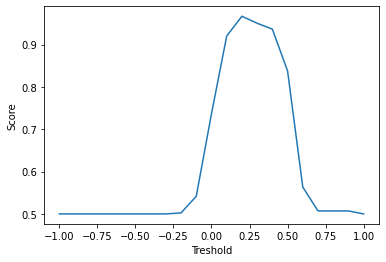

In [212]:
plt.plot(store.parameters, store.scores)
plt.xlabel('Treshold')
plt.ylabel('Score')

In [224]:
treshold, _ = store.get_best()
tresholds = np.around(list(np.arange( float(treshold - 0.09), float(treshold + 0.1), 0.01)), 2)
tresholds

array([0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ])

In [225]:
store = cv(model, tresholds, test_sub_df, chunksize=50000)
store.get_best()

/home/a.y.igoshin/virtual_environments/main/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: generator 'chunk_iterator' raised StopIteration
/home/a.y.igoshin/virtual_environments/main/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: generator 'chunk_iterator' raised StopIteration
  # Remove the CWD from sys.path while we load stuff.


Accuracy: 0.9331875
Accuracy: 0.9408343
Accuracy: 0.94734085
Accuracy: 0.95272124
Accuracy: 0.957072
Accuracy: 0.9605399
Accuracy: 0.96333206
Accuracy: 0.9655025
Accuracy: 0.9671088
Accuracy: 0.9612914
Accuracy: 0.9622441
Accuracy: 0.9630031
Accuracy: 0.96356964
Accuracy: 0.9639165
Accuracy: 0.9641873
Accuracy: 0.95731384
Accuracy: 0.95041
Accuracy: 0.9505004
Accuracy: 0.95055


(0.2, 0.9671088)

In [226]:
store.dataframe()

,param,score
0,0.12,0.933187
1,0.13,0.940834
2,0.14,0.947341
3,0.15,0.952721
4,0.16,0.957072
5,0.17,0.960540
6,0.18,0.963332
7,0.19,0.965503
8,0.20,0.967109
9,0.21,0.961291


Text(0, 0.5, 'Score')

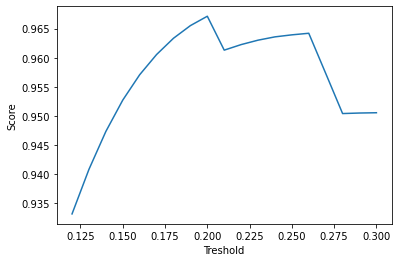

In [227]:
plt.plot(store.parameters, store.scores)
plt.xlabel('Treshold')
plt.ylabel('Score')

In [228]:
treshold, _ = store.get_best()
tresholds = np.around(list(np.arange( float(treshold - 0.009), float(treshold + 0.01), 0.001)), 3)
tresholds

array([0.191, 0.192, 0.193, 0.194, 0.195, 0.196, 0.197, 0.198, 0.199,
       0.2  , 0.201, 0.202, 0.203, 0.204, 0.205, 0.206, 0.207, 0.208,
       0.209, 0.21 ])

In [229]:
store = cv(model, tresholds, test_sub_df, chunksize=50000)
store.get_best()

/home/a.y.igoshin/virtual_environments/main/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: generator 'chunk_iterator' raised StopIteration
/home/a.y.igoshin/virtual_environments/main/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: generator 'chunk_iterator' raised StopIteration
  # Remove the CWD from sys.path while we load stuff.


Accuracy: 0.9657268
Accuracy: 0.96590304
Accuracy: 0.96606153
Accuracy: 0.9662334
Accuracy: 0.96639955
Accuracy: 0.96654516
Accuracy: 0.96670693
Accuracy: 0.9668263
Accuracy: 0.96697205
Accuracy: 0.9671088
Accuracy: 0.9672298
Accuracy: 0.9673697
Accuracy: 0.9674846
Accuracy: 0.96761
Accuracy: 0.9677365
Accuracy: 0.9678662
Accuracy: 0.96796095
Accuracy: 0.9610454
Accuracy: 0.9611705
Accuracy: 0.9612914


(0.207, 0.96796095)

In [230]:
store.dataframe()

,param,score
0,0.191,0.965727
1,0.192,0.965903
2,0.193,0.966062
3,0.194,0.966233
4,0.195,0.966400
5,0.196,0.966545
6,0.197,0.966707
7,0.198,0.966826
8,0.199,0.966972
9,0.200,0.967109


Text(0, 0.5, 'Score')

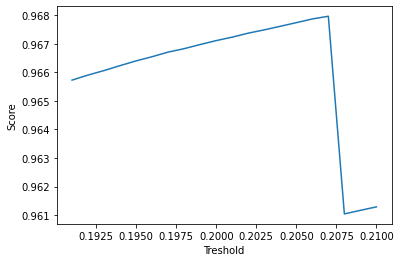

In [231]:
plt.plot(store.parameters, store.scores)
plt.xlabel('Treshold')
plt.ylabel('Score')

In [232]:
treshold, _ = store.get_best()

In [233]:
save_treshold(treshold)